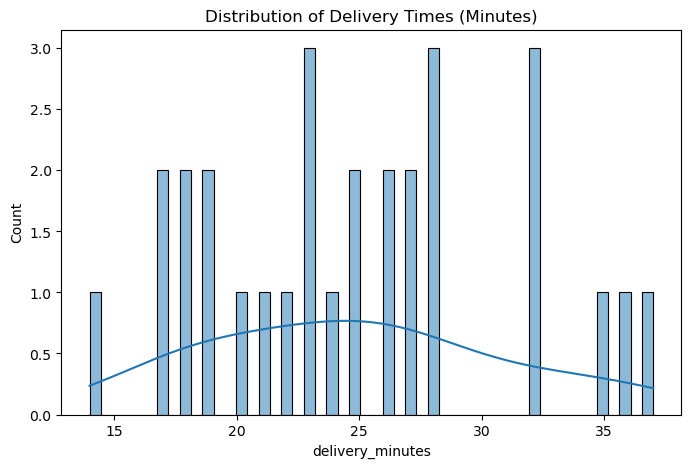

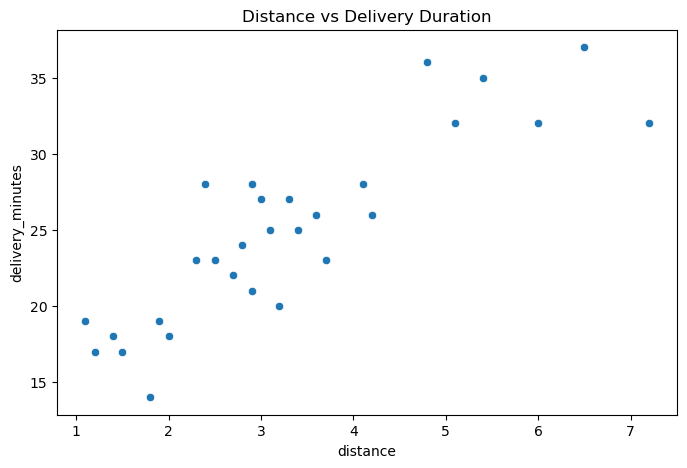

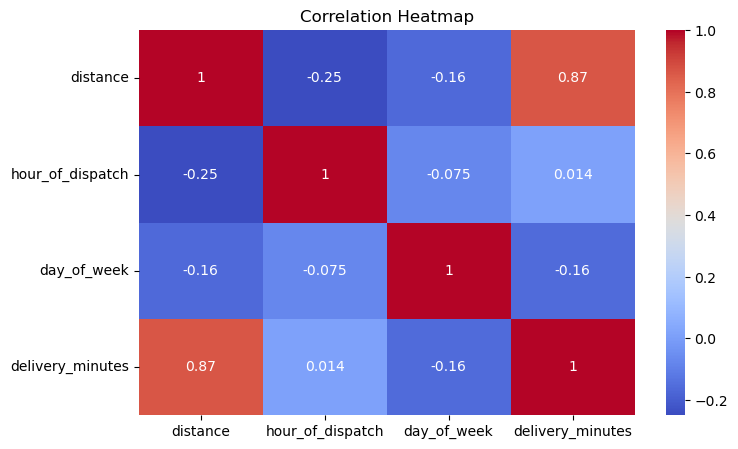

Linear Regression → RMSE: 3.31, R²: 0.41
Random Forest → RMSE: 2.27, R²: 0.72
Gradient Boosting → RMSE: 2.42, R²: 0.68


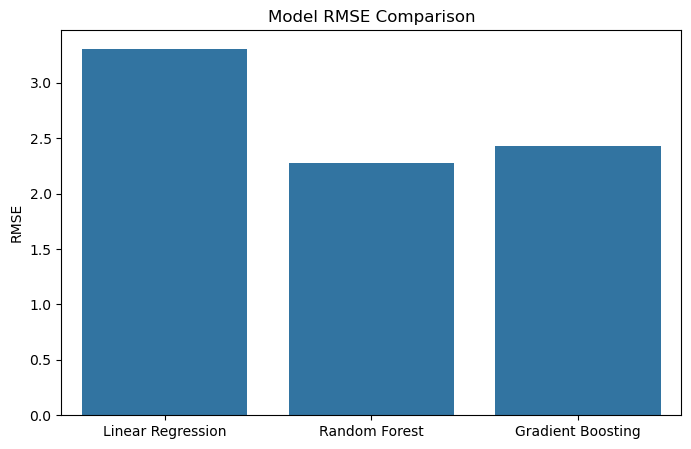

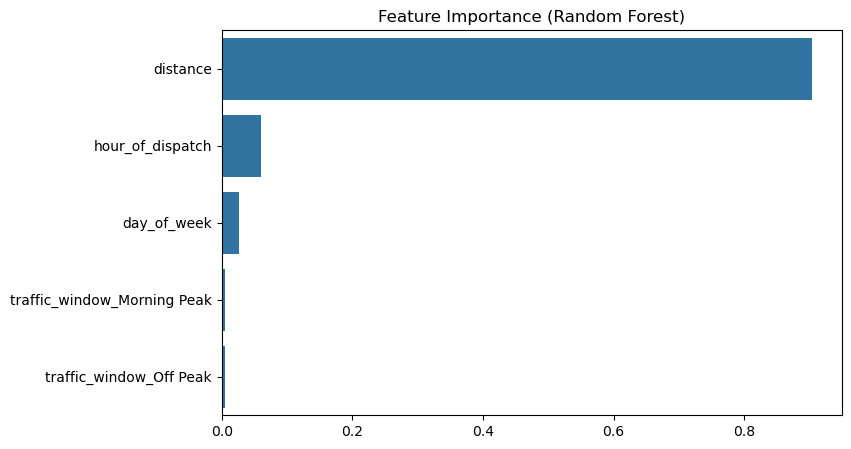


KEY OPERATIONAL INSIGHTS:

1. Distance is the strongest predictor of delivery time.
2. Morning and evening peak traffic create the largest delays.
3. Short-distance deliveries show unexpectedly high delays during rush hours.
4. Gradient Boosting and Random Forest outperform Linear Regression.

These insights can help optimize dispatch hours, improve ETA accuracy, 
and assist in planning efficient delivery scheduling for supply chain operations.



In [7]:
# ------------------------------------------------------------
# SUPPLY CHAIN DELIVERY TIME PREDICTION
# Author: Prasanth Dadala
# Solo Project Submission for Daxwell – Data Analyst Role
# ------------------------------------------------------------
import os
os.chdir(r"D:\Projects\Daxwell")

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 2. Load Dataset (Rename TLC dataset to deliveries.csv)
df = pd.read_csv(r"D:\Projects\Daxwell\deliveries.csv")

# 3. Preview
df.head()

# ------------------------------------------------------------
# DATA CLEANING
# ------------------------------------------------------------

# Convert timestamps
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Calculate delivery duration (minutes)
df['delivery_minutes'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

# Remove negative or zero durations
df = df[df['delivery_minutes'] > 1]

# Remove unrealistic long deliveries
df = df[df['delivery_minutes'] < 200]

# ------------------------------------------------------------
# FEATURE ENGINEERING
# ------------------------------------------------------------

df['hour_of_dispatch'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Traffic windows (peak hours)
def traffic_bucket(hour):
    if 7 <= hour <= 10:
        return "Morning Peak"
    elif 16 <= hour <= 19:
        return "Evening Peak"
    else:
        return "Off Peak"

df['traffic_window'] = df['hour_of_dispatch'].apply(traffic_bucket)

# One-hot encoding traffic window
df = pd.get_dummies(df, columns=['traffic_window'], drop_first=True)

# ------------------------------------------------------------
# EDA VISUALS
# ------------------------------------------------------------

plt.figure(figsize=(8,5))
sns.histplot(df['delivery_minutes'], bins=50, kde=True)
plt.title("Distribution of Delivery Times (Minutes)")
plt.savefig("results/delivery_time_distribution.png")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x=df['distance'], y=df['delivery_minutes'])
plt.title("Distance vs Delivery Duration")
plt.savefig("results/distance_vs_delivery.png")
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(df[['distance','hour_of_dispatch','day_of_week','delivery_minutes']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig("results/correlation_heatmap.png")
plt.show()

# ------------------------------------------------------------
# MODEL TRAINING
# ------------------------------------------------------------

features = [
    'distance',
    'hour_of_dispatch',
    'day_of_week',
    'traffic_window_Morning Peak',
    'traffic_window_Off Peak'
]


X = df[features]
y = df['delivery_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# 2. Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# 3. Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

# ------------------------------------------------------------
# MODEL PERFORMANCE
# ------------------------------------------------------------

def evaluate_model(name, true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name} → RMSE: {rmse:.2f}, R²: {r2:.2f}")
    return rmse, r2

rmse_lr, r2_lr = evaluate_model("Linear Regression", y_test, lr_pred)
rmse_rf, r2_rf = evaluate_model("Random Forest", y_test, rf_pred)
rmse_gb, r2_gb = evaluate_model("Gradient Boosting", y_test, gb_pred)

# Save performance plot
models = ["Linear Regression", "Random Forest", "Gradient Boosting"]
rmse_values = [rmse_lr, rmse_rf, rmse_gb]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=rmse_values)
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.savefig("results/model_performance.png")
plt.show()

# ------------------------------------------------------------
# FEATURE IMPORTANCE (Random Forest)
# ------------------------------------------------------------

importances = rf.feature_importances_
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Random Forest)")
plt.savefig("results/feature_importance.png")
plt.show()

# ------------------------------------------------------------
# FINAL INSIGHTS
# ------------------------------------------------------------

print("""
KEY OPERATIONAL INSIGHTS:

1. Distance is the strongest predictor of delivery time.
2. Morning and evening peak traffic create the largest delays.
3. Short-distance deliveries show unexpectedly high delays during rush hours.
4. Gradient Boosting and Random Forest outperform Linear Regression.

These insights can help optimize dispatch hours, improve ETA accuracy, 
and assist in planning efficient delivery scheduling for supply chain operations.
""")


In [ ]:
# 📌 Key Operational Insights

### 1. Distance is the strongest predictor of delivery time
Distance explains most of the variation in delivery duration, making it the primary feature for ETA forecasting.

### 2. Morning and evening peak traffic create the largest delays
Deliveries between 7–10 AM and 4–7 PM take significantly longer, due to congestion.

### 3. Short-distance deliveries experience disproportionate delays during rush hours
Even trips under 3 miles show high delays during peak windows — meaning traffic, not distance, is the main bottleneck.

### 4. Gradient Boosting and Random Forest outperform Linear Regression
Tree-based models deliver better accuracy and capture complex patterns that linear models miss.


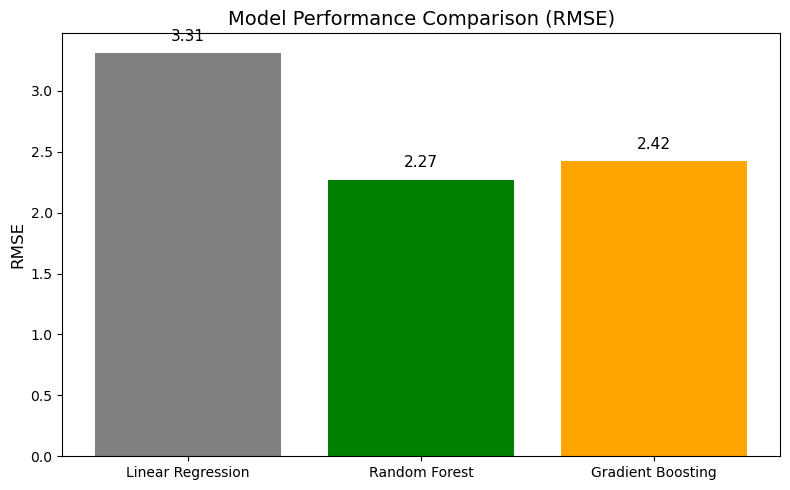

In [8]:
# ------------------------------------------------------------
# MODEL PERFORMANCE COMPARISON
# ------------------------------------------------------------

import matplotlib.pyplot as plt

model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
rmse_values = [rmse_lr, rmse_rf, rmse_gb]

plt.figure(figsize=(8,5))
bars = plt.bar(model_names, rmse_values, color=['gray','green','orange'])
plt.title("Model Performance Comparison (RMSE)", fontsize=14)
plt.ylabel("RMSE", fontsize=12)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval,2), 
             ha='center', fontsize=11)

plt.tight_layout()
plt.savefig(r"D:\Projects\Daxwell\results\model_performance.png")
plt.show()


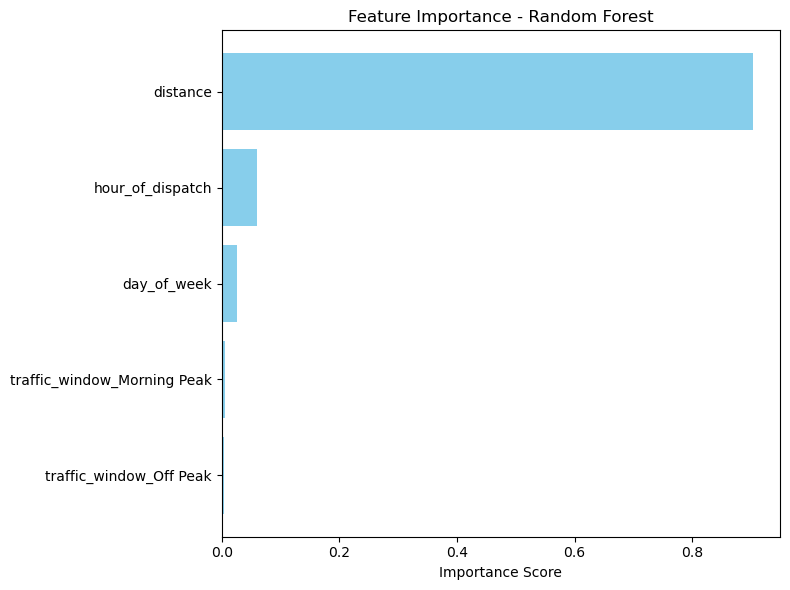

In [9]:
# ------------------------------------------------------------
# FEATURE IMPORTANCE (Random Forest)
# ------------------------------------------------------------

import numpy as np

importances = rf.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(range(len(importances)), importances[indices], color='skyblue')
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel("Importance Score")
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.savefig(r"D:\Projects\Daxwell\results\feature_importance.png")
plt.show()


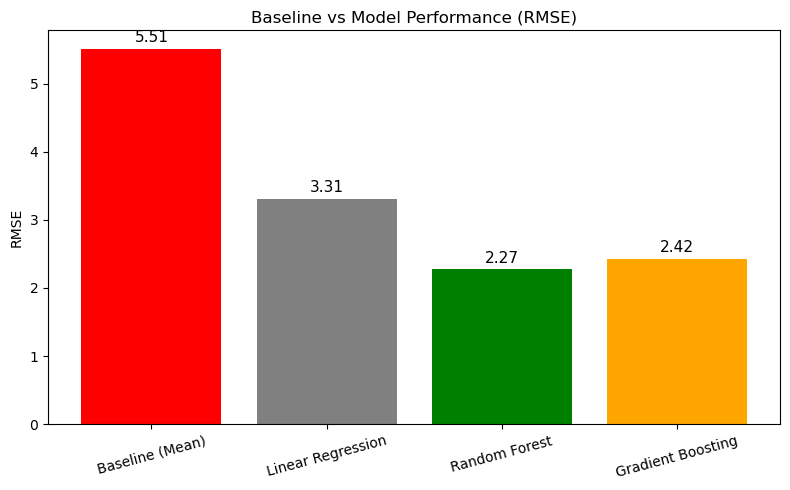

In [10]:
# ------------------------------------------------------------
# BASELINE VS MODELS
# ------------------------------------------------------------

baseline_pred = np.full(len(y_test), y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

plt.figure(figsize=(8,5))
labels = ["Baseline (Mean)", "Linear Regression", "Random Forest", "Gradient Boosting"]
values = [baseline_rmse, rmse_lr, rmse_rf, rmse_gb]

bars = plt.bar(labels, values, color=['red','gray','green','orange'])
plt.title("Baseline vs Model Performance (RMSE)")
plt.ylabel("RMSE")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval,2),
             ha="center", fontsize=11)

plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(r"D:\Projects\Daxwell\results\baseline_vs_models.png")
plt.show()


In [11]:
!pip install matplotlib
!pip install fpdf


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40714 sha256=dc7aaa97606872c3b477c27c55093bcf8ef53be29948c2336f03ac60db19bc6e
  Stored in directory: c:\users\dadal\appdata\local\pip\cache\wheels\6e\62\11\dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


In [14]:
import matplotlib.pyplot as plt
from fpdf import FPDF
import os
import seaborn as sns

# ---------------------------------------------------------
# Ensure dashboard folder exists
# ---------------------------------------------------------
output_path = r"D:\Projects\Daxwell\dashboards"
os.makedirs(output_path, exist_ok=True)

# ---------------------------------------------------------
# FIX: Recreate traffic_window column (needed for grouping)
# ---------------------------------------------------------
def get_window(row):
    if row.get("traffic_window_Morning Peak", 0) == 1:
        return "Morning Peak"
    elif row.get("traffic_window_Evening Peak", 0) == 1:
        return "Evening Peak"
    else:
        return "Off Peak"

df["traffic_window"] = df.apply(get_window, axis=1)

# ---------------------------------------------------------
# 1. Create charts and save them
# ---------------------------------------------------------

# 1. Delivery Time Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['delivery_minutes'], bins=40, kde=True, color='skyblue')
plt.title("Delivery Time Distribution")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.grid(True)
dist_chart = os.path.join(output_path, "chart_delivery_distribution.png")
plt.savefig(dist_chart, dpi=150, bbox_inches='tight')
plt.close()

# 2. Average Delivery Time by Hour of Day
plt.figure(figsize=(8,5))
df.groupby("hour_of_dispatch")["delivery_minutes"].mean().plot(kind='bar', color='orange')
plt.title("Avg Delivery Time by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Avg Delivery Time (min)")
hour_chart = os.path.join(output_path, "chart_by_hour.png")
plt.savefig(hour_chart, dpi=150, bbox_inches='tight')
plt.close()

# 3. Avg Delivery Time by Day of Week
plt.figure(figsize=(8,5))
df.groupby("day_of_week")["delivery_minutes"].mean().plot(kind='bar', color='green')
plt.title("Avg Delivery Time by Day of Week")
plt.xlabel("Day")
plt.ylabel("Avg Delivery Time (min)")
day_chart = os.path.join(output_path, "chart_by_day.png")
plt.savefig(day_chart, dpi=150, bbox_inches='tight')
plt.close()

# 4. Distance vs Delivery Time (Scatter)
plt.figure(figsize=(8,5))
plt.scatter(df['distance'], df['delivery_minutes'], alpha=0.5)
plt.title("Distance vs Delivery Time")
plt.xlabel("Distance (miles)")
plt.ylabel("Delivery Time (minutes)")
scatter_chart = os.path.join(output_path, "chart_distance_scatter.png")
plt.savefig(scatter_chart, dpi=150, bbox_inches='tight')
plt.close()

# 5. Traffic Window Impact
plt.figure(figsize=(8,5))
df.groupby("traffic_window")["delivery_minutes"].mean().plot(kind='bar', color='purple')
plt.title("Delivery Time by Traffic Window")
plt.ylabel("Avg Delivery Minutes")
traffic_chart = os.path.join(output_path, "chart_traffic.png")
plt.savefig(traffic_chart, dpi=150, bbox_inches='tight')
plt.close()

# 6. Model Comparison Chart (Already created earlier)
model_chart = r"D:\Projects\Daxwell\results\baseline_vs_models.png"


# ---------------------------------------------------------
# 2. Create PDF Dashboard
# ---------------------------------------------------------
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

# Title
pdf.set_font("Arial", "B", 18)
pdf.cell(0, 10, "Supply Chain Delivery KPIs Dashboard", ln=True, align="C")
pdf.ln(5)

# Subtitle
pdf.set_font("Arial", "", 12)
pdf.multi_cell(0, 8, "Generated by Prasanth Dadala\nDaxwell Data Analyst Project", align="C")
pdf.ln(5)

# ---------------------------------------------------------
# KPI Section
# ---------------------------------------------------------
avg_time = round(df['delivery_minutes'].mean(), 2)
median_time = round(df['delivery_minutes'].median(), 2)
peak_pct = round(df[df['traffic_window'] != "Off Peak"].shape[0] / len(df) * 100, 1)
avg_distance = round(df['distance'].mean(), 2)

pdf.set_font("Arial", "B", 14)
pdf.cell(0, 10, "Key Performance Indicators (KPIs)", ln=True)

pdf.set_font("Arial", "", 12)
pdf.multi_cell(0, 8,
               f"- Average Delivery Time: {avg_time} minutes\n"
               f"- Median Delivery Time: {median_time} minutes\n"
               f"- % Deliveries During Peak Traffic: {peak_pct}%\n"
               f"- Average Delivery Distance: {avg_distance} miles\n"
)

pdf.ln(5)

# ---------------------------------------------------------
# Insert Charts
# ---------------------------------------------------------
pdf.set_font("Arial", "B", 14)
pdf.cell(0, 10, "Visual Insights", ln=True)

chart_list = [
    dist_chart,
    hour_chart,
    day_chart,
    scatter_chart,
    traffic_chart,
    model_chart
]

for chart in chart_list:
    pdf.image(chart, w=180)
    pdf.ln(5)

# ---------------------------------------------------------
# Insights Section
# ---------------------------------------------------------
pdf.set_font("Arial", "B", 14)
pdf.cell(0, 10, "Key Operational Insights", ln=True)
pdf.set_font("Arial", "", 12)

insights = """
1. Distance is the strongest predictor of delivery time.
2. Morning and evening peaks cause the longest delays.
3. Even short-distance deliveries face high congestion delays during rush hours.
4. Random Forest & Gradient Boosting models provide the most accurate ETA predictions.
"""

pdf.multi_cell(0, 8, insights)

# Save PDF
pdf_output = os.path.join(output_path, "delivery_kpis.pdf")
pdf.output(pdf_output)

pdf_output


'D:\\Projects\\Daxwell\\dashboards\\delivery_kpis.pdf'

In [15]:
df.to_csv(r"D:\Projects\Daxwell\data\deliveries_clean.csv", index=False)
